<a href="https://colab.research.google.com/github/swap-10/U-Net-Tensorflow/blob/main/unet_yard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

![UNet Architecture Image](UNet_arch.jpg "UNet Architecture")

UNet: Convolutional Networks for Biomedical Image Segmentation - Ronneberger et. al. 2015 https://arxiv.org/pdf/1505.04597.pdf

In [2]:
class DoubleConvModule(tf.keras.layers.Layer):
    def __init__(self, filters, mid_channels=None):
        super(DoubleConvModule, self).__init__()
        if not mid_channels:
            mid_channels = filters
        self.conv1 = tf.keras.layers.Conv2D(
            filters=mid_channels,
            kernel_size=(3,3),
            padding='valid',
            )
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.relu1 = tf.keras.layers.ReLU()

        self.conv2 = tf.keras.layers.Conv2D(
            filters=filters,
            kernel_size=(3,3),
            padding='valid'
        )
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.relu2 = tf.keras.layers.ReLU()

    def call(self, input_tensor, training=False):
        x = self.conv1(input_tensor)
        x = self.bn1(x, training=training)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = self.relu2(x)

        return x

conv_test = DoubleConvModule(32)
conv_test

In [3]:
class Downscale(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(Downscale, self).__init__()
        self.mp2d_1 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
        self.doubleconv = DoubleConvModule(filters)
    
    def call(self, input_tensor, training=False):
        x = self.mp2d_1(input_tensor)
        return self.doubleconv(x, training=training)

downscale_test = Downscale(32)
downscale_test

In [4]:
class Upscale(tf.keras.layers.Layer):
    def __init__(self, filters, bilinear=False):
        super().__init__()
        self.filters = filters
        if bilinear:
            self.upsample = tf.keras.layers.UpSampling2D(
                size=(2,2),
                interpolation='bilinear')
        else:
            self.upsample = tf.keras.layers.Conv2DTranspose(filters, kernel_size=(2,2), strides=(2,2), padding='valid')
        self.doubleconv = DoubleConvModule(filters)

    def call(self, input_tensor, skip_connection):
        x1 = self.upsample(input_tensor)
        x2 = skip_connection
        x2 = tf.image.resize(x2, size=[x1.shape[1], x1.shape[2]])
        x = tf.keras.layers.Concatenate()([x1, x2])
        return self.doubleconv(x)

upscale_test = Upscale(32)
upscale_test(tf.random.normal(shape=(5,28,28,3)), tf.random.normal(shape=(5,64,64,32)))
        

<tf.Tensor: shape=(5, 52, 52, 32), dtype=float32, numpy=
array([[[[3.23245972e-01, 3.65267128e-01, 2.58643329e-01, ...,
          1.76152900e-01, 4.08259451e-01, 0.00000000e+00],
         [0.00000000e+00, 3.14625978e-01, 0.00000000e+00, ...,
          2.54885685e-02, 5.54974258e-01, 0.00000000e+00],
         [0.00000000e+00, 7.00337216e-02, 2.73858421e-02, ...,
          1.46971598e-01, 2.82457560e-01, 0.00000000e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 2.52638012e-03, 0.00000000e+00],
         [0.00000000e+00, 3.26328933e-01, 0.00000000e+00, ...,
          0.00000000e+00, 5.11618137e-01, 0.00000000e+00],
         [0.00000000e+00, 3.51661235e-01, 2.96192199e-01, ...,
          2.29721785e-01, 2.91829109e-01, 0.00000000e+00]],

        [[0.00000000e+00, 1.94798112e-01, 4.17084694e-01, ...,
          7.09828213e-02, 3.22941273e-01, 0.00000000e+00],
         [0.00000000e+00, 5.73458314e-01, 0.00000000e+00, ...,
          

In [5]:
class ClassifyConv(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(ClassifyConv, self).__init__()
        self.conv = tf.keras.layers.Conv2D(filters, kernel_size=(1,1))
    
    def call(self, input_tensor, original_size):
        x = tf.image.resize(input_tensor, original_size)
        return self.conv(x)

classify_conv_test = ClassifyConv(32)
classify_conv_test

### Putting together the U-net

In [6]:
class UNet(tf.keras.Model):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inp = DoubleConvModule(64)
        
        self.down1 = Downscale(128)
        self.down2 = Downscale(256)
        self.down3 = Downscale(512)
        self.down4 = Downscale(1024)
        
        self.up1 = Upscale(512, bilinear=bilinear)
        self.up2 = Upscale(256, bilinear=bilinear)
        self.up3 = Upscale(128, bilinear=bilinear)
        self.up4 = Upscale(64, bilinear=bilinear)

        self.out = ClassifyConv(n_classes)

    def call(self, input_tensor):
        self.original_size = [input_tensor.shape[1], input_tensor.shape[2]]
        x1 = self.inp(input_tensor)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        xf = self.down4(x4)
        
        xf = self.up1(xf, x4)
        xf = self.up2(xf, x3)
        xf = self.up3(xf, x2)
        xf = self.up4(xf, x1)
        
        x = self.out(xf, self.original_size)

        return x

    def build_graph(self):
        x = tf.keras.Input(shape=(572, 572, 3))
        return tf.keras.Model(inputs=x, outputs=self.call(x))


model = UNet(n_channels=3, n_classes=2)
model.build(input_shape=(5, 572, 572, 3))
model(tf.random.normal(shape=(5, 572, 572, 3)))

<tf.Tensor: shape=(5, 572, 572, 2), dtype=float32, numpy=
array([[[[ 6.55274764e-02, -6.73943684e-02],
         [ 4.83379737e-02, -1.06456960e-02],
         [ 3.40580642e-02,  4.23492305e-02],
         ...,
         [ 9.14634392e-02, -2.42033061e-02],
         [ 7.11764842e-02, -2.15120688e-02],
         [ 3.65833938e-02, -3.47404019e-03]],

        [[ 4.99996915e-02, -3.37241441e-02],
         [ 4.49314155e-02, -1.47418864e-02],
         [ 4.19471748e-02,  4.69888141e-03],
         ...,
         [ 6.35448918e-02,  2.24956367e-02],
         [ 4.11297269e-02,  1.42946709e-02],
         [ 1.49519872e-02,  7.14428723e-03]],

        [[ 2.75919121e-02,  1.12062160e-04],
         [ 3.61714587e-02, -1.29313264e-02],
         [ 4.42152359e-02, -2.30324008e-02],
         ...,
         [ 4.81519997e-02,  5.46093807e-02],
         [ 2.38690469e-02,  3.89216058e-02],
         [ 8.51005199e-04,  1.41716031e-02]],

        ...,

        [[ 9.12966058e-02, -4.64275368e-02],
         [ 6.30073175e-02

In [ ]:
model.build_graph().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 572, 572, 3  0           []                               
                                )]                                                                
                                                                                                  
 double_conv_module_3 (DoubleCo  (None, 568, 568, 64  39232      ['input_1[0][0]']                
 nvModule)                      )                                                                 
                                                                                                  
 downscale_1 (Downscale)        (None, 280, 280, 12  222464      ['double_conv_module_3[0][0]']   
                                8)                                                            

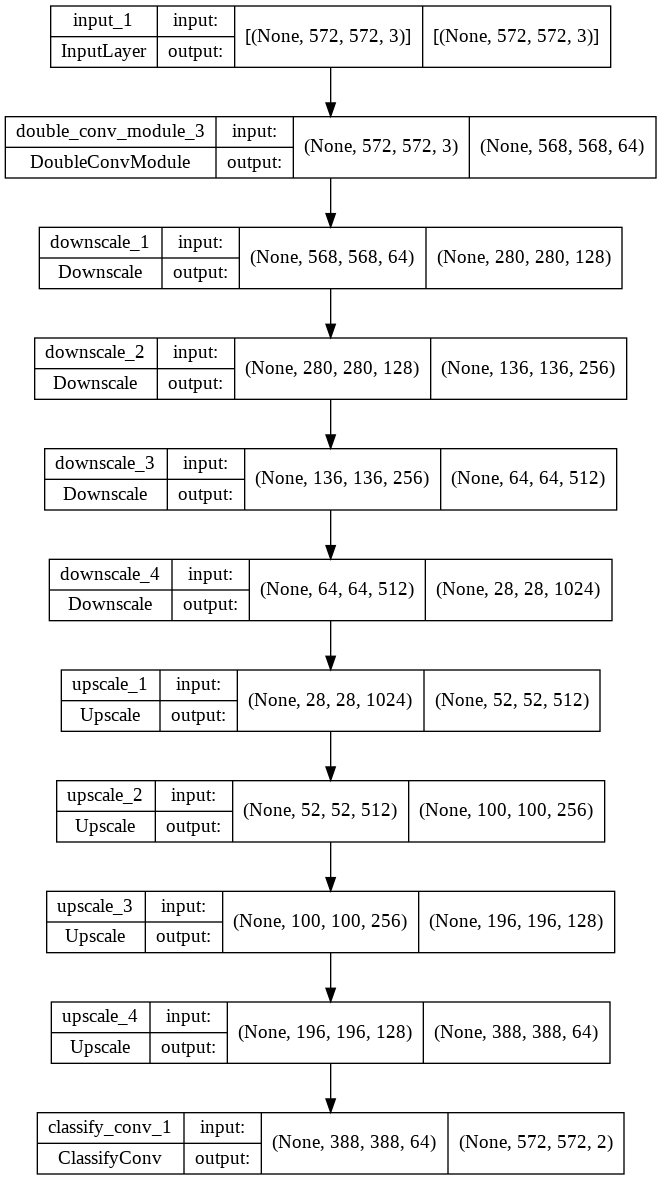

In [ ]:
tf.keras.utils.plot_model(
    model.build_graph(),
    to_file="unet_model.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True
    )

In [7]:
import tensorflow_datasets as tfds
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteZLV7CM/oxford_iiit_pet-train.tfrecord


  0%|          | 0/3680 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteZLV7CM/oxford_iiit_pet-test.tfrecord


  0%|          | 0/3669 [00:00<?, ? examples/s]

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [15]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask = input_mask - 1
  return input_image, input_mask

def load_image(data):
  input_image = tf.image.resize(data['image'], (572, 572))
  input_mask = tf.image.resize(data['segmentation_mask'], (572, 572))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

3680


In [30]:
##### H-PARAMS #####
TRAIN_LENGTH = info.splits['train'].num_examples
print(TRAIN_LENGTH)
BATCH_SIZE = 4
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
EPOCHS = 10
VAL_SUBSPLITS = 5
VALIDATION_STEPS = (info.splits['test'].num_examples // BATCH_SIZE) // VAL_SUBSPLITS

3680


In [16]:
train_images = dataset['train'].map(load_image)
test_images = dataset['test'].map(load_image)

In [31]:
train_batches = (
    train_images
    .batch(BATCH_SIZE)
    .repeat()
)

test_batches = test_images.batch(BATCH_SIZE)

In [18]:
import matplotlib.pyplot as plt

def display(img_list):
  plt.figure(figsize=(10,10))
  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(img_list)):
    plt.subplot(1, len(img_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(img_list[i]))
    plt.axis('off')
  plt.show()

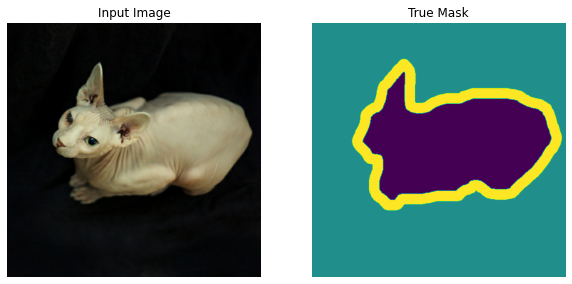

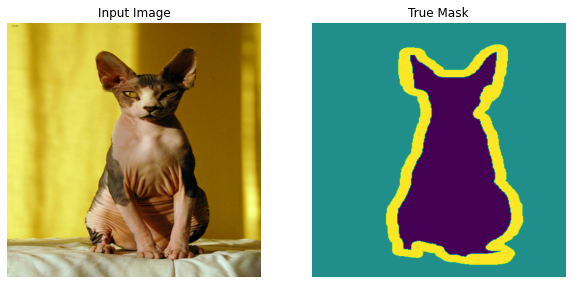

In [32]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [20]:
model.summary()

Model: "u_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 double_conv_module_3 (Doubl  multiple                 39232     
 eConvModule)                                                    
                                                                 
 downscale_1 (Downscale)     multiple                  222464    
                                                                 
 downscale_2 (Downscale)     multiple                  887296    
                                                                 
 downscale_3 (Downscale)     multiple                  3544064   
                                                                 
 downscale_4 (Downscale)     multiple                  14166016  
                                                                 
 upscale_1 (Upscale)         multiple                  9180672   
                                                             

In [33]:
N_CLASSES = 3
model = UNet(n_channels=3, n_classes=N_CLASSES)
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
    )

In [22]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display(image[0], mask[0], create_mask(pred_mask))
  else:
    display([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis, ...]))])
  

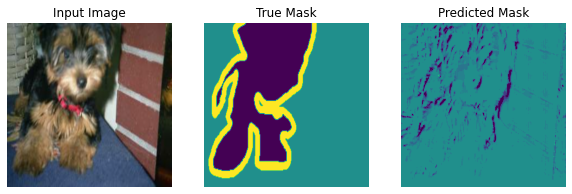

In [23]:
show_predictions()

In [28]:
import IPython
class DisplayPredictionCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    IPython.display.clear_output(wait=True)
    show_predictions()
    print(f"Sample Prediction after epoch {epoch+1}\n")

class EarlyStoppingCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    if logs.get('accuracy') >= 0.93:
      print("Reached 93% accuracy so stopping training\n")
      self.model.stop_training=True

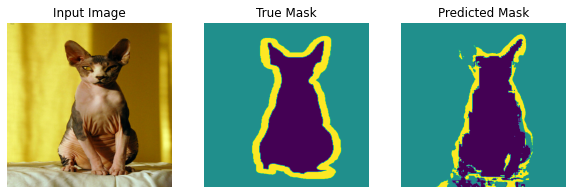

Sample Prediction after epoch 7

920/920 [==============================] - 881s 958ms/step - loss: 0.5140 - accuracy: 0.7869 - val_loss: 0.8589 - val_accuracy: 0.6541
Epoch 8/10
606/920 [==================>...........] - ETA: 4:41 - loss: 0.4947 - accuracy: 0.7957

In [ ]:
history = model.fit(
    train_batches,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=test_batches,
    callbacks=[DisplayPredictionCallback(), EarlyStoppingCallback()],
    verbose=1
)